In [1]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("INFS3208 Project").getOrCreate()
sc = spark.sparkContext

# create schemas for world suicide table
schema1 = StructType([StructField("Country",StringType(), True),\
                        StructField("Year",IntegerType(), True),\
                        StructField("Sex",StringType(), True),\
                        StructField("Age",StringType(), True),\
                        StructField("Suicide_No",IntegerType(), True),\
                        StructField("Population",IntegerType(), True)])

# create schemas for world happiness report table
schema2 = StructType([StructField("Country",StringType(), True),\
                        StructField("Region",StringType(), True),\
                        StructField("Happiness_Score",FloatType(), True),\
                        StructField("GDP_per_capital",FloatType(), True),\
                        StructField("Social_Support",FloatType(), True),\
                        StructField("Freedom_of_choice",FloatType(), True),\
                        StructField("Generosity",FloatType(), True),\
                     ])

# create schemas for life expectancy table
schema3 = StructType([StructField("Country",StringType(), True),\
                        StructField("Year",IntegerType(), True),\
                        StructField("Status",StringType(), True),\
                        StructField("Life_expectancy",FloatType(), True),\
                        StructField("Adult_Mortality",IntegerType(), True),\
                        StructField("Infant_death",IntegerType(), True)
                     ])

# Import Data
suicide = spark.read.format("csv").option("header","true").schema(schema1).load("hdfs://namenode/suicide.csv")
happiness = spark.read.format("csv").option("header","true").schema(schema2).load("hdfs://namenode/happiness.csv")
life_expectancy = spark.read.format("csv").option("header","true").schema(schema3).load("hdfs://namenode/life_expectancy.csv")
suicide.show()
happiness.show()
life_expectancy.show()

+-------+----+------+-----------+----------+----------+
|Country|Year|   Sex|        Age|Suicide_No|Population|
+-------+----+------+-----------+----------+----------+
|Albania|1985|female|15-24 years|      null|    277900|
|Albania|1985|female|25-34 years|      null|    246800|
|Albania|1985|female|35-54 years|      null|    267500|
|Albania|1985|female| 5-14 years|      null|    298300|
|Albania|1985|female|55-74 years|      null|    138700|
|Albania|1985|female|  75+ years|      null|     34200|
|Albania|1985|  male|15-24 years|      null|    301400|
|Albania|1985|  male|25-34 years|      null|    264200|
|Albania|1985|  male|35-54 years|      null|    296700|
|Albania|1985|  male| 5-14 years|      null|    325800|
|Albania|1985|  male|55-74 years|      null|    132500|
|Albania|1985|  male|  75+ years|      null|     21100|
|Albania|1986|female|15-24 years|      null|    283900|
|Albania|1986|female|25-34 years|      null|    252100|
|Albania|1986|female|35-54 years|      null|    

In [2]:
# remove duplication data
suicide_dup = suicide.dropDuplicates()
suicide_drop_num = suicide.count() - suicide_dup.count()
print("Remove " + str(suicide_drop_num) + " rows due to duplication from Suicide table")

life_dup = life_expectancy.dropDuplicates()
life_drop_num = life_expectancy.count() - life_dup.count()
print("Remove " + str(life_drop_num) + " rows due to duplication from Life Expectancy table")

happiness_dup = happiness.dropDuplicates()
happiness_drop_num = happiness.count() - happiness_dup.count()
print("Remove " + str(happiness_drop_num) + " rows due to duplication from World Happiness Report table")

# remove null values
suicide_null = suicide_dup.na.drop()
suicide_null_num = suicide_dup.count() - suicide_null.count()
print("Remove " + str(suicide_null_num) + " rows due to the null value in Suicide table")

happiness_null = happiness_dup.na.drop()
happiness_null_num = happiness_dup.count() - happiness_null.count()
print("Remove " + str(happiness_null_num) + " rows due to the null value in World Happiness Report table")

life_null = life_dup.na.drop()
life_null_num = life_dup.count() - life_null.count()
print("Remove " + str(life_null_num) + " rows due to the null value in Life Expectancy table")

Remove 0 rows due to duplication from Suicide table
Remove 0 rows due to duplication from Life Expectancy table
Remove 0 rows due to duplication from World Happiness Report table
Remove 7716 rows due to the null value in Suicide table
Remove 0 rows due to the null value in World Happiness Report table
Remove 10 rows due to the null value in Life Expectancy table


In [3]:
# The number of countries that participated in all of three studies
suicide_null.registerTempTable("Suicide")
life_null.registerTempTable("Life")
happiness_null.registerTempTable("Happiness")

spark.sql("SELECT COUNT(DISTINCT Country) AS Country_in_suicideStudy FROM Suicide").show()
spark.sql("SELECT COUNT(DISTINCT Country) AS Country_in_lifeExpectancyStudy FROM Life").show()
spark.sql("SELECT COUNT(DISTINCT Country) AS Country_in_worldHappinessStudy FROM Happiness").show()

spark.sql("SELECT COUNT(DISTINCT Suicide.Country) AS Num_of_Country_in_allStudy FROM Life, Suicide, Happiness WHERE Life.Country = Suicide.Country  AND Life.Country = Happiness.Country AND Happiness.Country = Suicide.Country ").show()
spark.sql("SELECT DISTINCT Suicide.Country AS Country_in_allStudy FROM Life, Suicide, Happiness WHERE Life.Country = Suicide.Country  AND Life.Country = Happiness.Country AND Happiness.Country = Suicide.Country ").show()

+-----------------------+
|Country_in_suicideStudy|
+-----------------------+
|                    118|
+-----------------------+

+------------------------------+
|Country_in_lifeExpectancyStudy|
+------------------------------+
|                           183|
+------------------------------+

+------------------------------+
|Country_in_worldHappinessStudy|
+------------------------------+
|                           149|
+------------------------------+

+--------------------------+
|Num_of_Country_in_allStudy|
+--------------------------+
|                        74|
+--------------------------+

+-------------------+
|Country_in_allStudy|
+-------------------+
|           Paraguay|
|             Sweden|
|        Philippines|
|          Singapore|
|             Turkey|
|            Germany|
|           Maldives|
|             France|
|             Greece|
|          Sri Lanka|
|           Slovakia|
|          Argentina|
|            Belgium|
|            Ecuador|
|            Alba

<AxesSubplot:title={'center':'Top 20 countries with highest number of suicide'}, xlabel='Country'>

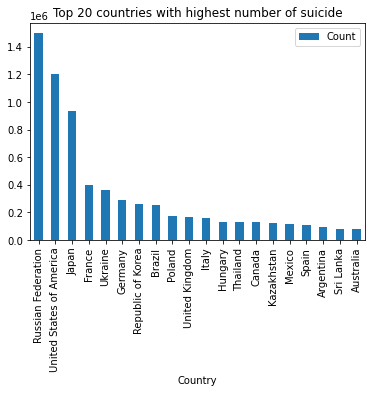

In [4]:
# Top 20 Countries with highest number of suicide number
q1 = spark.sql("SELECT Country, SUM(Suicide_No) as Count FROM Suicide GROUP BY Country ORDER BY SUM(Suicide_No) DESC")
q1 = q1.toPandas()
q1.iloc[0:20].plot(kind='bar',x='Country',y='Count', title = 'Top 20 countries with highest number of suicide')

<AxesSubplot:title={'center':'Top 20 countries with highest happiness score'}, xlabel='Country'>

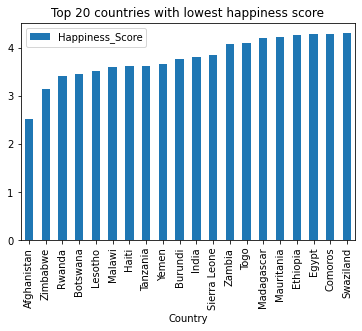

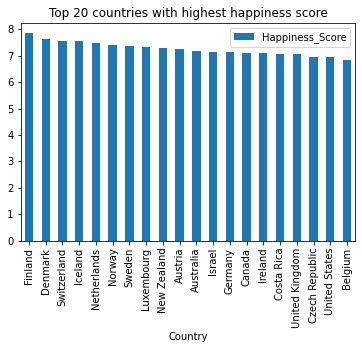

In [5]:
# Top 20 Countries with lowest happiness score
q4 = spark.sql("SELECT Country, Happiness_Score FROM Happiness ORDER BY Happiness_Score ASC")
q4 = q4.toPandas()
q4.iloc[0:20].plot(kind='bar',x='Country',y='Happiness_Score', title = 'Top 20 countries with lowest happiness score')

# Top 20 Countries with highest happiness score
q9 = spark.sql("SELECT Country, Happiness_Score FROM Happiness ORDER BY Happiness_Score DESC")
q9 = q9.toPandas()
q9.iloc[0:20].plot(kind='bar',x='Country',y='Happiness_Score', title = 'Top 20 countries with highest happiness score')

<AxesSubplot:title={'center':'Top 20 countries with highest life expectancy'}, xlabel='Country'>

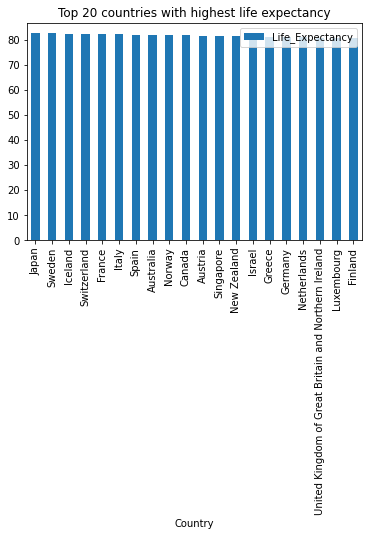

In [6]:
# Top 20 Countries with highest life expectancy
q10 = spark.sql("SELECT Country, AVG(Life_expectancy) AS Life_Expectancy FROM Life GROUP BY Country ORDER BY AVG(Life_expectancy) DESC")
q10 = q10.toPandas()
q10.iloc[0:20].plot(kind='bar',x='Country',y='Life_Expectancy', title = 'Top 20 countries with highest life expectancy')

<AxesSubplot:title={'center':'Number of suicide number in different age ranges'}, xlabel='Age'>

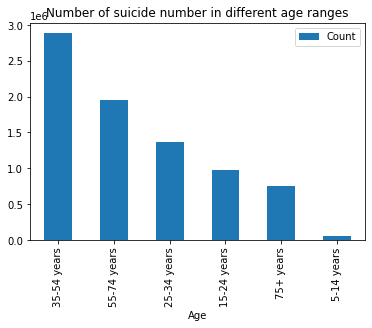

In [7]:
# Number of suicide number in different age ranges
q2 = spark.sql("SELECT Age, SUM(Suicide_No) as Count FROM Suicide GROUP BY Age ORDER BY SUM(Suicide_No) DESC")
q2 = q2.toPandas()
q2.iloc[0:10].plot(kind='bar',x='Age',y='Count', title = 'Number of suicide number in different age ranges')

<AxesSubplot:title={'center':'Top years with highest number of suicide'}, xlabel='Year'>

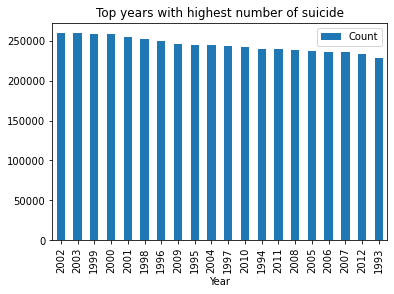

In [8]:
# Top years with highest suicide number
q3 = spark.sql("SELECT Year, SUM(Suicide_No) as Count FROM Suicide GROUP BY Year ORDER BY SUM(Suicide_No) DESC")
q3 = q3.toPandas()
q3.iloc[0:20].plot(kind='bar',x='Year',y='Count', title = 'Top years with highest number of suicide')

<AxesSubplot:title={'center':'Top countries with highest number of female suicide'}, xlabel='Country'>

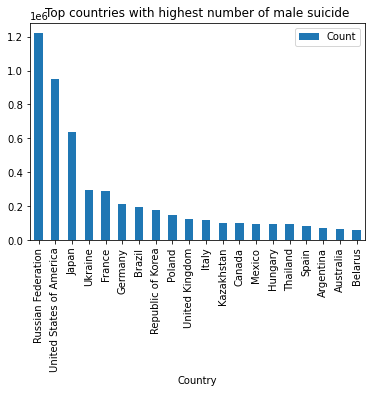

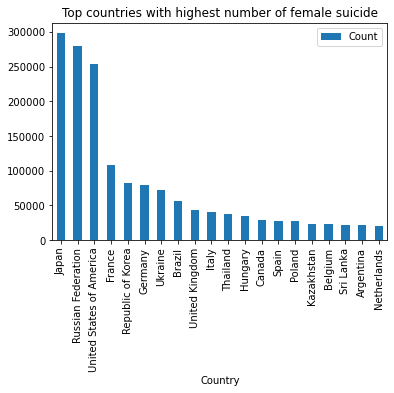

In [9]:
# Country with most male suicide numbers
q5 = spark.sql("""SELECT Country, SUM(Suicide_No) AS Count FROM Suicide WHERE Sex = "male" GROUP BY Country ORDER BY SUM(Suicide_No) DESC""")
q5 = q5.toPandas()
q5.iloc[0:20].plot(kind='bar',x='Country',y='Count', title = 'Top countries with highest number of male suicide')

# Country with most female suicide numbers
q6 = spark.sql("""SELECT Country, SUM(Suicide_No) AS Count FROM Suicide WHERE Sex = "female" GROUP BY Country ORDER BY SUM(Suicide_No) DESC""")
q6 = q6.toPandas()
q6.iloc[0:20].plot(kind='bar',x='Country',y='Count', title = 'Top countries with highest number of female suicide')


<AxesSubplot:title={'center':'Top regions with highest happiness score'}, xlabel='Region'>

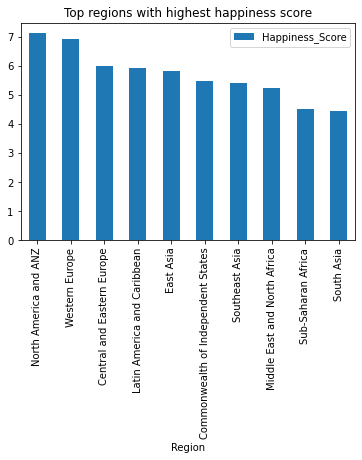

In [10]:
# The region with highest happiness score
q7 = spark.sql("SELECT Region, AVG(Happiness_Score) AS Happiness_Score FROM Happiness GROUP BY Region ORDER BY AVG(Happiness_Score) DESC")
q7 = q7.toPandas()
q7.iloc[0:20].plot(kind='bar',x='Region',y='Happiness_Score', title = 'Top regions with highest happiness score')

<AxesSubplot:title={'center':'Top 20 countries with highest happiness score'}, xlabel='Country'>

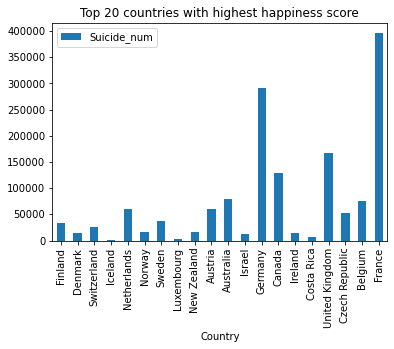

In [11]:
# The suicide number of country with highest happiness score
q11 = spark.sql("SELECT Suicide.Country AS Country, SUM(Suicide_No) AS Suicide_num, Happiness.Happiness_Score FROM Suicide, Happiness WHERE Suicide.Country = Happiness.Country GROUP BY Suicide.Country,Happiness.Happiness_Score ORDER BY Happiness.Happiness_Score DESC")
q11 = q11.toPandas()
q11.iloc[0:20].plot(kind='bar',x='Country',y='Suicide_num', title = 'Top 20 countries with highest happiness score')